In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None) 
from sklearn import preprocessing
import datetime as dt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('sample.csv', sep=',')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-07,WN,WN,WN,3263,WN,N211WN,3263,12896,LBB,"Lubbock, TX",11259,DAL,"Dallas, TX",1550,1545.0,-5.0,10.0,1555.0,1644.0,4.0,1655,1648.0,-7.0,0.0,NaN,0.0,N,65.0,63.0,49.0,1.0,293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-06,AA,AA,AA,2514,AA,N883NN,2514,12478,JFK,"New York, NY",10423,AUS,"Austin, TX",835,829.0,-6.0,20.0,849.0,1138.0,60.0,1153,1238.0,45.0,0.0,NaN,0.0,N,258.0,309.0,229.0,1.0,1521.0,0.0,0.0,45.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2019-07-12,AS,AS,AS,19,AS,N297AK,19,13204,MCO,"Orlando, FL",14747,SEA,"Seattle, WA",1925,1918.0,-7.0,21.0,1939.0,2223.0,5.0,2235,2228.0,-7.0,0.0,NaN,0.0,N,370.0,370.0,344.0,1.0,2554.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-08-23,DL,DL,DL,884,DL,N341DN,884,13487,MSP,"Minneapolis, MN",14679,SAN,"San Diego, CA",1802,1821.0,19.0,19.0,1840.0,1951.0,5.0,1948,1956.0,8.0,0.0,NaN,0.0,N,226.0,215.0,191.0,1.0,1532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-26,DL,DL,DL,3057,DL,N123DQ,3057,14908,SNA,"Santa Ana, CA",14869,SLC,"Salt Lake City, UT",1315,1312.0,-3.0,10.0,1322.0,1556.0,6.0,1603,1602.0,-1.0,0.0,NaN,0.0,N,108.0,110.0,94.0,1.0,588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# cols in test file
df = df[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier', 'mkt_carrier_fl_num', \
         'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name', \
         'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dup', 'crs_elapsed_time', \
         'flights', 'distance', 'arr_delay']].copy()

In [4]:
# drop columns that are highly correlated with others
df = df.drop(columns=['branded_code_share', 'mkt_carrier', 'op_unique_carrier', 'op_carrier_fl_num', 'flights', 'origin_airport_id', 'origin_city_name', 'dest_airport_id', 'dest_city_name', 'tail_num', 'dup'])

In [5]:
# drop rows with null values
df = df.dropna()

In [6]:
df.shape

(9814, 10)

In [7]:
df.dtypes

fl_date                object
mkt_unique_carrier     object
mkt_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time            int64
crs_arr_time            int64
crs_elapsed_time      float64
distance              float64
arr_delay             float64
dtype: object

In [8]:
# look at outliers
flights_over_120h_late = df[df['arr_delay']>120].shape[0]
percent = flights_over_120h_late/df.shape[0]
print(flights_over_120h_late, percent)
 

278 0.02832687996739352


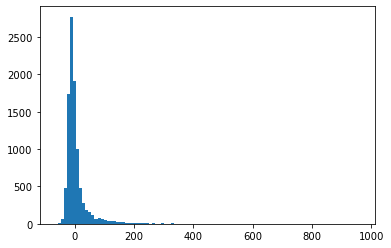

In [9]:
plt.hist(df['arr_delay'], bins=100);

/Users/pavneetbajwa/opt/anaconda3/envs/labs/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='arr_delay'>

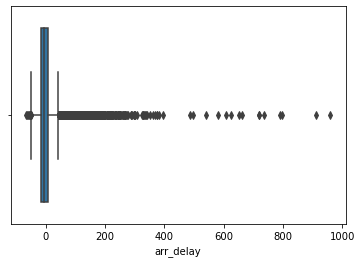

In [10]:
sns.boxplot(df['arr_delay'])

In [11]:
df['arr_delay'].describe()

count    9814.000000
mean        5.703587
std        48.576373
min       -67.000000
25%       -15.000000
50%        -6.000000
75%         8.000000
max       959.000000
Name: arr_delay, dtype: float64

In [12]:
IQR = (df['arr_delay'].quantile(0.75)-df['arr_delay'].quantile(0.25))

In [13]:
lower_outlier = df['arr_delay'].quantile(0.25) - 1.5*IQR
upper_outlier = df['arr_delay'].quantile(0.75) + 1.5*IQR
print(lower_outlier, upper_outlier)

-49.5 42.5


In [14]:
# get rid of approximately 3% of the top delays (consider them outliers)
df = df[(df['arr_delay'] < upper_outlier) & (df['arr_delay'] > lower_outlier)]

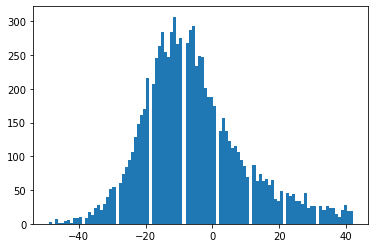

In [15]:
plt.hist(df['arr_delay'], bins=100);

In [17]:
# function to label encode desired columns
def label_encode(df, cols):
    le = preprocessing.LabelEncoder()
    for i in cols:
        df[i] = le.fit_transform(df[i].values)
    return df

In [18]:
df.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay
0,2019-12-07,WN,3263,LBB,DAL,1550,1655,65.0,293.0,-7.0
2,2019-07-12,AS,19,MCO,SEA,1925,2235,370.0,2554.0,-7.0
3,2019-08-23,DL,884,MSP,SAN,1802,1948,226.0,1532.0,8.0
4,2019-11-26,DL,3057,SNA,SLC,1315,1603,108.0,588.0,-1.0
5,2019-11-08,AS,3451,FAT,SAN,1150,1304,74.0,314.0,2.0


In [19]:
# define columns to encode
cols_to_encode = ['mkt_unique_carrier', 'origin', 'dest']
df_encoded = label_encode(df, cols_to_encode)

In [20]:
df_encoded.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay
0,2019-12-07,10,3263,169,73,1550,1655,65.0,293.0,-7.0
2,2019-07-12,1,19,189,261,1925,2235,370.0,2554.0,-7.0
3,2019-08-23,3,884,212,253,1802,1948,226.0,1532.0,8.0
4,2019-11-26,3,3057,288,272,1315,1603,108.0,588.0,-1.0
5,2019-11-08,1,3451,105,253,1150,1304,74.0,314.0,2.0


In [21]:
# convert flight date from string to datetime
df_encoded['fl_date'] = pd.to_datetime(df_encoded['fl_date'])
df_encoded.dtypes

fl_date               datetime64[ns]
mkt_unique_carrier             int64
mkt_carrier_fl_num             int64
origin                         int64
dest                           int64
crs_dep_time                   int64
crs_arr_time                   int64
crs_elapsed_time             float64
distance                     float64
arr_delay                    float64
dtype: object

In [22]:
# extract additional information from flight date
df_encoded['year'] = df_encoded['fl_date'].dt.year
df_encoded['month'] = df_encoded['fl_date'].dt.month
df_encoded['day'] = df_encoded['fl_date'].dt.day
df_encoded['dayofweek'] = df_encoded['fl_date'].dt.dayofweek

In [23]:
df_encoded.head()

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,year,month,day,dayofweek
0,2019-12-07,10,3263,169,73,1550,1655,65.0,293.0,-7.0,2019,12,7,5
2,2019-07-12,1,19,189,261,1925,2235,370.0,2554.0,-7.0,2019,7,12,4
3,2019-08-23,3,884,212,253,1802,1948,226.0,1532.0,8.0,2019,8,23,4
4,2019-11-26,3,3057,288,272,1315,1603,108.0,588.0,-1.0,2019,11,26,1
5,2019-11-08,1,3451,105,253,1150,1304,74.0,314.0,2.0,2019,11,8,4


In [24]:
df_encoded = df_encoded.drop(columns='fl_date')

In [25]:
# copy desired data into a new data frame
data = df_encoded[['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay']].copy()

In [26]:
# look at correlation among remaining variables
df_corr = data.corr()

<AxesSubplot:>

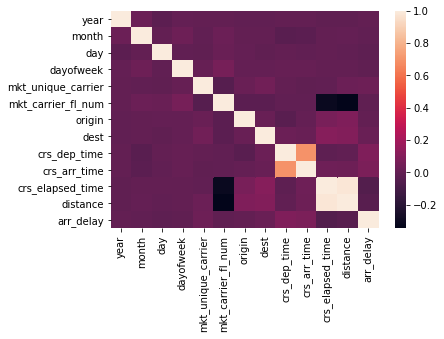

In [27]:
sns.heatmap(df_corr)

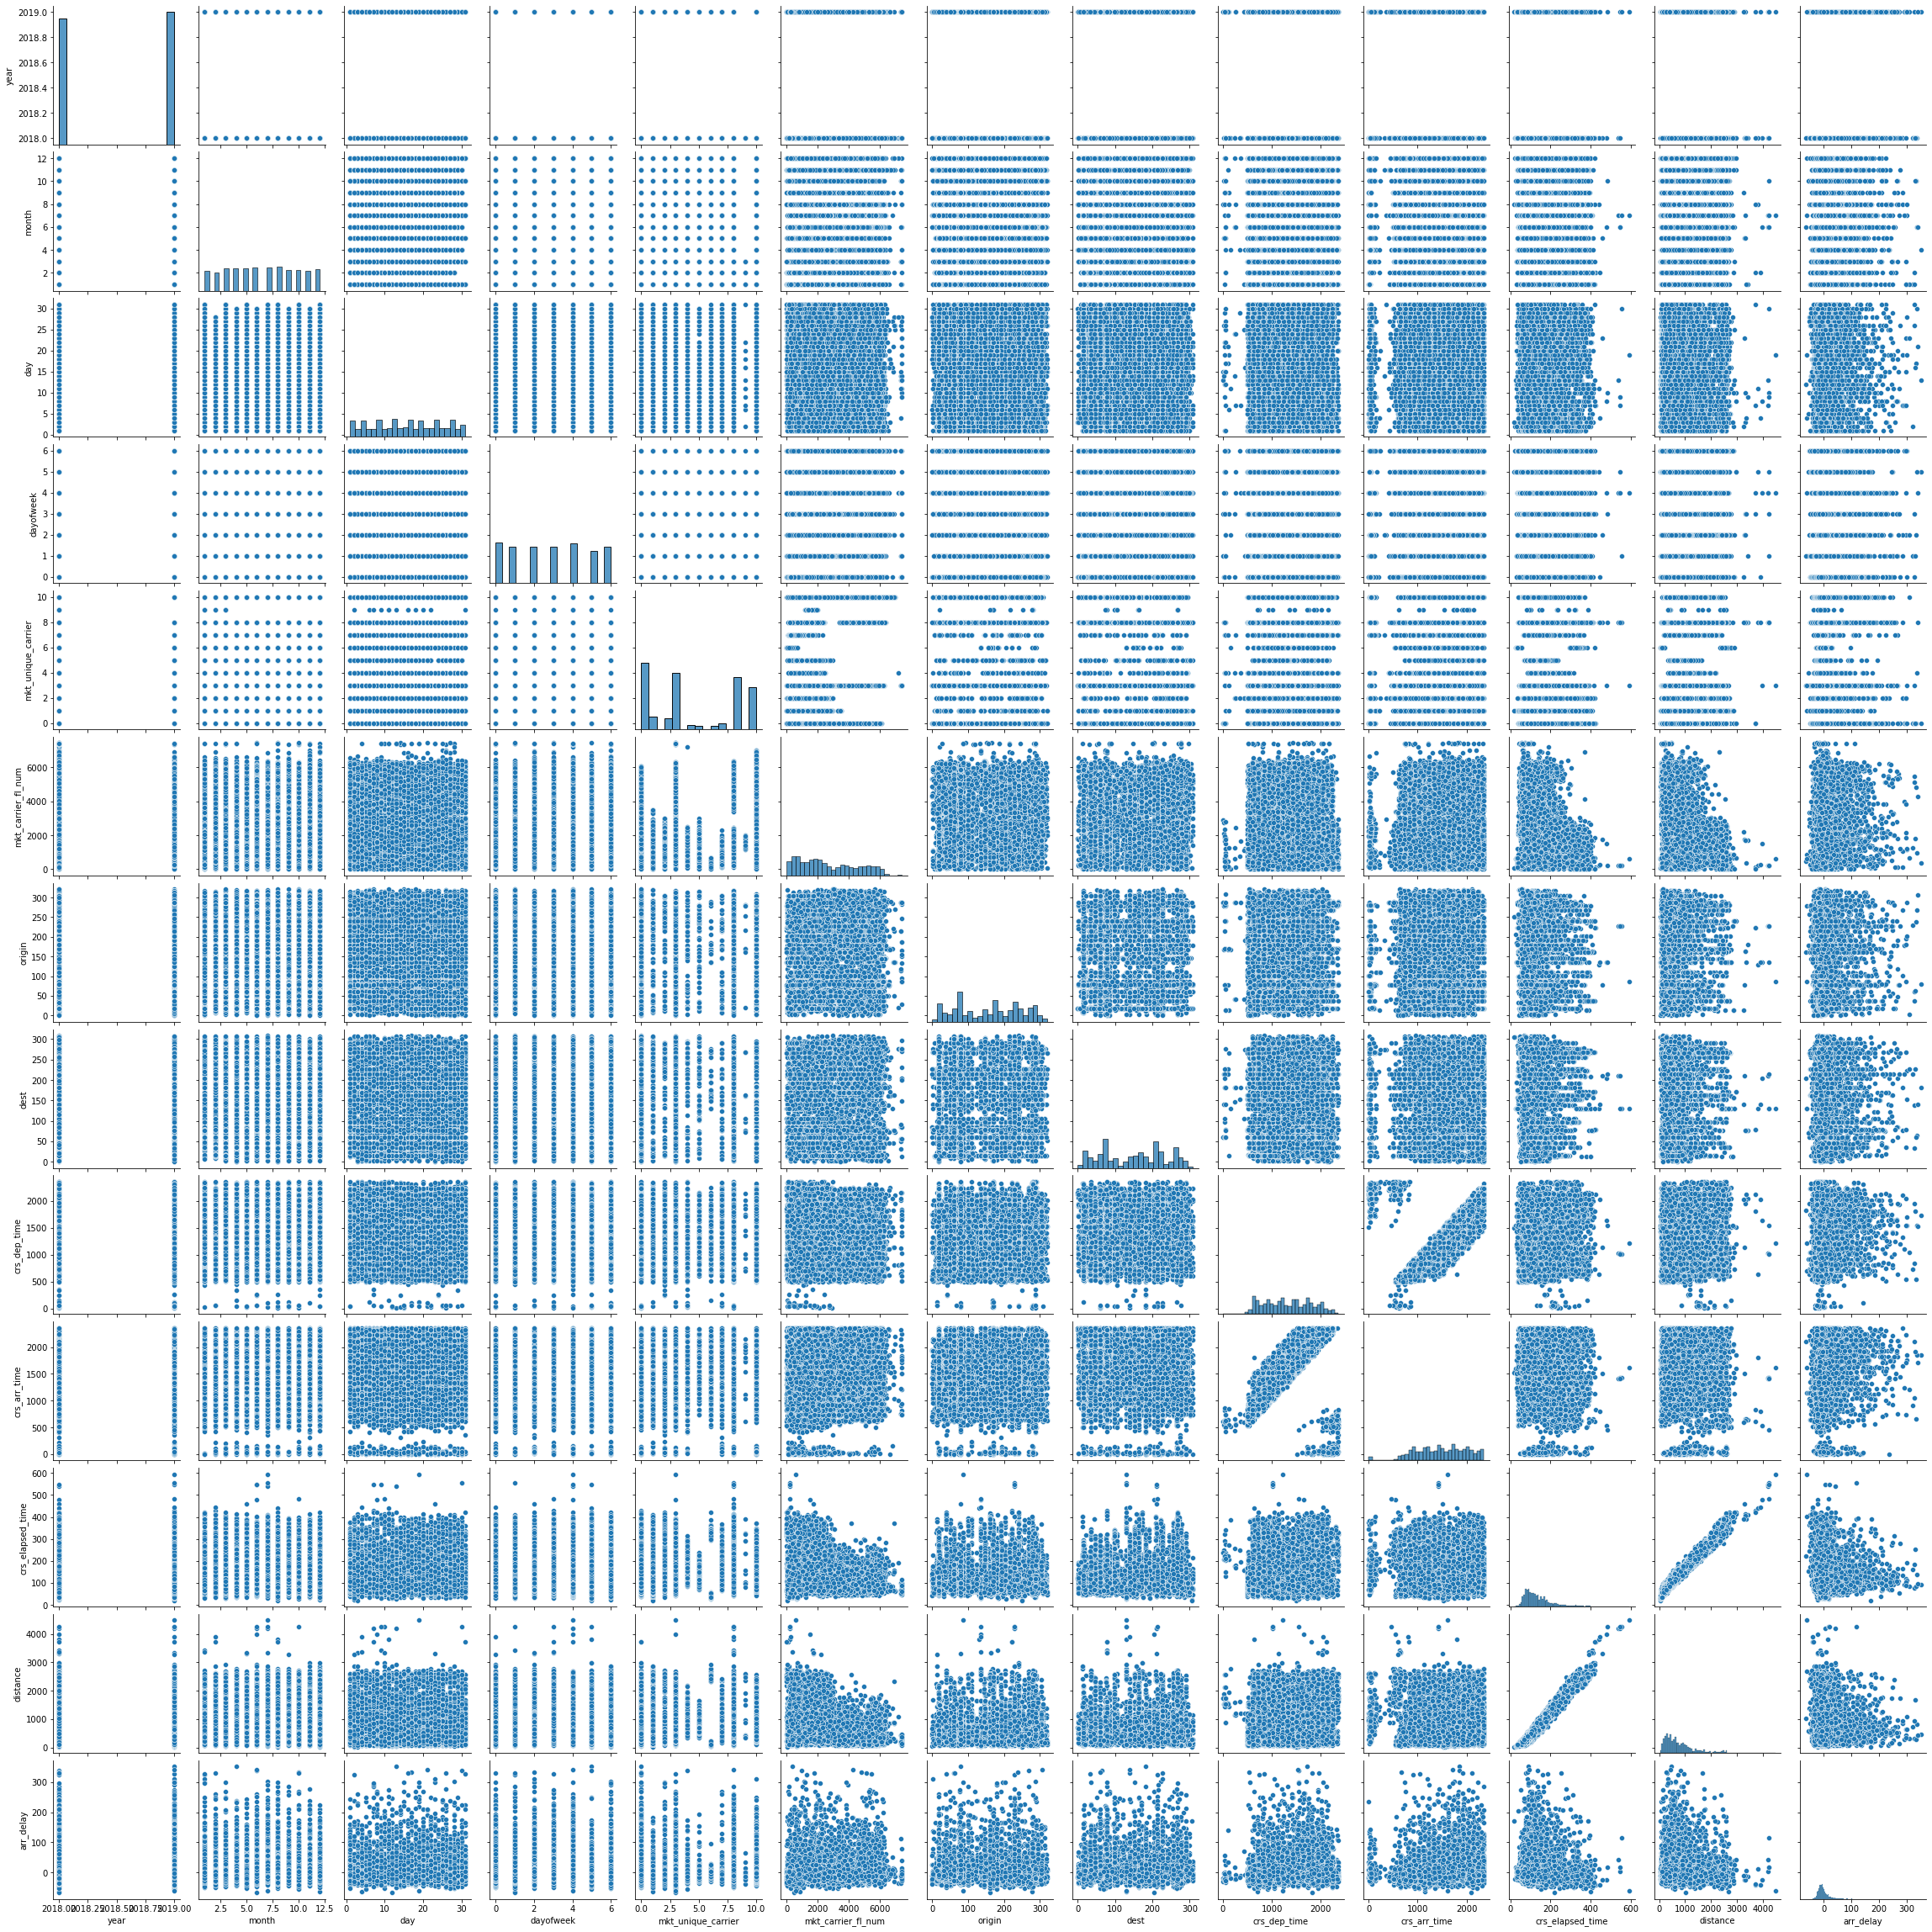

In [20]:
# identify any patterns among the variables
sns.pairplot(data)
plt.show()

### Read in the clean test file ---> test_data.csv

In [42]:
data = pd.read_csv('test_data.csv', sep=',')
data = data.drop(columns=['Unnamed: 0'])
data.head()

,year,month,day,dayofweek,mkt_unique_carrier,mkt_carrier_fl_num,origin,dest,dep_h,arr_h,crs_elapsed_time,distance,arr_delay,mean_delay_carrier,mean_delay_origin,mean_delay_dest,mean_delay_month,mean_delay_dep_h,mean_delay_arr_h
0,2019,12,7,5,10,3263,169,73,15,16,65.0,293.0,-7.0,-3.335329,-7.125000,-1.770115,-6.257028,-5.013183,-5.160714
1,2019,7,12,4,1,19,189,261,19,22,370.0,2554.0,-7.0,-5.131291,-5.808642,-4.428571,-4.024580,-4.714286,-3.833760
2,2019,8,23,4,3,884,212,253,18,19,226.0,1532.0,8.0,-7.359040,-7.946237,-5.622807,-5.141782,-2.829522,-4.671785
3,2019,11,26,1,3,3057,288,272,13,16,108.0,588.0,-1.0,-7.359040,-5.216667,-8.062992,-5.277778,-4.118000,-5.160714
4,2019,11,8,4,1,3451,105,253,11,13,74.0,314.0,2.0,-5.131291,-7.166667,-5.622807,-5.277778,-6.014706,-6.717557


In [55]:
data.columns

Index(['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier',
       'mkt_carrier_fl_num', 'origin', 'dest', 'dep_h', 'arr_h',
       'crs_elapsed_time', 'distance', 'arr_delay', 'mean_delay_carrier',
       'mean_delay_origin', 'mean_delay_dest', 'mean_delay_month',
       'mean_delay_dep_h', 'mean_delay_arr_h'],
      dtype='object')

### Scale data and do Train-Test split

In [43]:
scaler = preprocessing.StandardScaler()

In [44]:
X = data.drop(columns='arr_delay').values

In [45]:
y = data['arr_delay'].values

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [47]:
# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Run different models on the dataset

### Linear Regression

In [48]:
reg = LinearRegression()
k_folds = 5

# Cross-validation
cv_r2 = cross_val_score(reg, X_train, y_train, cv=k_folds, scoring='r2')

# Train model on the entire training set
reg.fit(X_train, y_train)

# Test the model
y_pred_linreg = reg.predict(X_test)

# Calculate metrics
r2_linreg = r2_score(y_test, y_pred_linreg)
rmse_linreg = mean_squared_error(y_test, y_pred_linreg, squared=False)

# Compare traing to test accuracy
linreg_training_accuracy = reg.score(X_train, y_train)
linreg_test_accuracy = reg.score(X_test, y_test)

# Print results
print('Linear Regression')
print('==================')
print(f'Cross-validated R^2\nMean: {cv_r2.mean():.4f}\nStd.: {cv_r2.std():.4f}')
print(f'R^2: {r2_linreg:.4f}')
print(f'RMSE: {rmse_linreg:.4f}')
print(f'Training accuracy: {linreg_training_accuracy:.4f}')
print(f'Test accuracy: {linreg_test_accuracy:.4f}')

Linear Regression
Cross-validated R^2
Mean: 0.0886
Std.: 0.0085
R^2: 0.0914
RMSE: 14.5629
Training accuracy: 0.0940
Test accuracy: 0.0914


### Polynomial Regression

#### Degree = 2

In [49]:
# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Calculate metrics
r2_polyreg = r2_score(y_test, ypoly_test_pred)
rmse_polyreg = mean_squared_error(y_test, ypoly_test_pred, squared=False)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 2')
print('============================================')
print(f'Number of polynomial features: {Xpoly_train.shape[1]}')
print(f'R^2: {r2_polyreg:.4f}')
print(f'RMSE: {rmse_polyreg:.4f}')
print(f'Training accuracy: {r2poly_train:.4f}\nTest accuracy: {r2poly_test:.4f}')

Linear Regression with Polynomial Degree = 2
Number of polynomial features: 190
R^2: 0.0678
RMSE: 14.7513
Training accuracy: 0.1289
Test accuracy: 0.0678


#### Degree = 3

In [50]:
# Create polynomial feature set and train model
Xpoly3_train = PolynomialFeatures(degree=3).fit_transform(X_train)
Xpoly3_test = PolynomialFeatures(degree=3).fit_transform(X_test)

# Train and test the model
reg.fit(Xpoly3_train, y_train)
ypoly3_train_pred = reg.predict(Xpoly3_train)
ypoly3_test_pred = reg.predict(Xpoly3_test)

# Calculate metrics
r2_polyreg3 = r2_score(y_test, ypoly3_test_pred)
rmse_polyreg3 = mean_squared_error(y_test, ypoly3_test_pred, squared=False)

# Check performance on train and test set
r2poly3_train = r2_score(y_train, ypoly3_train_pred)
r2poly3_test = r2_score(y_test, ypoly3_test_pred)

# Print results
print('Linear Regression with Polynomial Degree = 3')
print('============================================')
print(f'Number of polynomial features: {Xpoly3_train.shape[1]}')
print(f'R^2: {r2_polyreg3:.4f}')
print(f'RMSE: {rmse_polyreg3:.4f}')
print(f'Training accuracy: {r2poly3_train:.4f}\nTest accuracy: {r2poly3_test:.4f}')

Linear Regression with Polynomial Degree = 3
Number of polynomial features: 1330
R^2: -0.3845
RMSE: 17.9772
Training accuracy: 0.2970
Test accuracy: -0.3845


### Ridge Regression

In [51]:
# define hyperparameters
param_grid = {'alpha': [0.1, 1, 5, 10]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_r2_rr = grid_result.best_score_  
best_alpha_rr = grid_result.best_params_['alpha']
best_rr_model = grid_result.best_estimator_ 

# Predict results
y_pred_rr = best_rr_model.predict(X_test)

# Calculate metrics
r2_test_rr = r2_score(y_test, y_pred_rr)
rmse_rr = mean_squared_error(y_test, y_pred_rr, squared=False)

# Check training and test accuracy
rr_training_accuracy = best_rr_model.score(X_train, y_train)
rr_test_accuracy = best_rr_model.score(X_test, y_test)

# Print results
print('Ridge Regression')
print('================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_rr:.4f}\nAlpha:\t{best_alpha_rr}')
print(f'R^2: {r2_test_rr:.4f}')
print(f'RMSE:  {rmse_rr:.4f}')
print(f'Training accuracy: {rr_training_accuracy:.4f},    Test accuracy: {rr_test_accuracy:.4f}')

Ridge Regression
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0887
Alpha:	10
R^2: 0.0912
RMSE:  14.5650
Training accuracy: 0.0940,    Test accuracy: 0.0912


### Ridge Regresssion on Polynomial (Degree = 3) with grid search

In [52]:
# define hyperparameters
param_grid = {'alpha': [50000, 60000, 80000, 100000]}

# create an instance of the model
rr = Ridge()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rr, param_grid=param_grid, cv=k_folds, scoring='r2', n_jobs=-1)
grid_result = grid.fit(Xpoly3_train, y_train)

# Check best hyperparameters and train the best model
best_r2_poly = grid_result.best_score_   
best_alpha_poly = grid_result.best_params_['alpha']
best_rr_poly = grid_result.best_estimator_

# Predict results
y_pred_poly = best_rr_poly.predict(Xpoly3_test)

# Calculate metrics
r2_test_poly = r2_score(y_test, y_pred_poly)
rmse_rr_poly = mean_squared_error(y_test, y_pred_poly, squared=False)

# Check training and test accuracy
rr_poly_training_accuracy = best_rr_poly.score(Xpoly3_train, y_train)
rr_poly_test_accuracy = best_rr_poly.score(Xpoly3_test, y_test)

# Print results
print('Ridge Regresssion on Polynomial (Degree = 3) with grid search')
print('=============================================================')
print(f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2_poly:.4f}\nAlpha:\t{best_alpha_poly}')
print(f'R^2 :{r2_test_poly:.4f}')
print(f'RMSE:  {rmse_rr_poly:.4f}')
print(f'Training accuracy: {rr_poly_training_accuracy:.4f},    Test accuracy: {rr_poly_test_accuracy:.4f}')

Ridge Regresssion on Polynomial (Degree = 3) with grid search
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0707
Alpha:	50000
R^2 :0.0758
RMSE:  14.6879
Training accuracy: 0.1152,    Test accuracy: 0.0758


### Random Forest Regressor

In [53]:
# define hyperparamters
params = {'n_estimators': [500, 1000, 5000], 'max_depth': [1, 3, 5, 7, 12]}

#Create an instance of the model
rf=RandomForestRegressor()
k_folds = 5

# perform cross validation and grid search
grid = GridSearchCV(estimator=rf, param_grid=params, cv=k_folds, scoring='r2', n_jobs=-1) 
grid_result = grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_n_estimators = grid_result.best_params_['n_estimators']
best_max_depth = grid_result.best_params_['max_depth']
best_model_rf = grid_result.best_estimator_

#rf_cv_score = cross_val_score(best_model_rf, X_train, y_train, cv=k_folds)

# Predict results
y_pred_rf = best_model_rf.predict(X_test)

# Calculate metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

# Check training and test accuracy
rf_training_accuracy = best_model_rf.score(X_train, y_train)
rf_test_accuracy = best_model_rf.score(X_test, y_test)

# Print results
print('Random Forest Regressor')
print('=======================')
print(f'Best number of Trees: {best_n_estimators}\nBest max depth:\t{best_max_depth}')
print(f'R^2 :{r2_rf:.4f}')
print(f'RMSE:  {rmse_rf:.4f}')
print(f'Training accuracy: {rf_training_accuracy:.4f},    Test accuracy: {rf_test_accuracy:.4f}')

Random Forest Regressor
Best number of Trees: 5000
Best max depth:	7
R^2 :0.0769
RMSE:  14.6792
Training accuracy: 0.2020,    Test accuracy: 0.0769


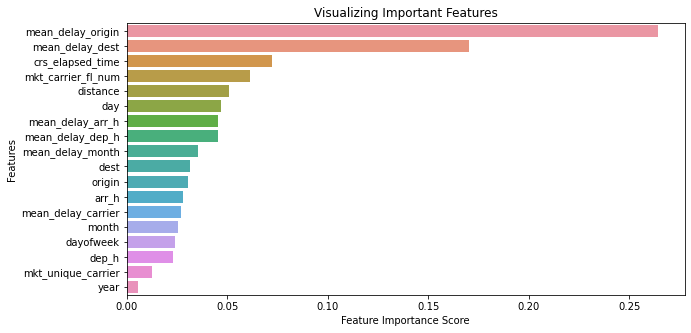

In [57]:
# Feature analysis for importance
cols = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier',
       'mkt_carrier_fl_num', 'origin', 'dest', 'dep_h', 'arr_h',
       'crs_elapsed_time', 'distance', 'mean_delay_carrier',
       'mean_delay_origin', 'mean_delay_dest', 'mean_delay_month',
       'mean_delay_dep_h', 'mean_delay_arr_h']

feature_imp = pd.Series(best_model_rf.feature_importances_,index=cols).sort_values(ascending=False)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10,5))
# Create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels 
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

### XGBRegressor

In [61]:
# define hyperparamters
params = {'objective': ['reg:linear'], 'learning_rate': [0.01, 0.05, 0.09], 'max_depth': [1, 3, 5, 7, 12], \
         'colsample_bytree': [0.7], 'alpha': [0.01, 0.1, 1], 'n_estimators': [150, 250, 500]}

#Create an instance of the model
xgb = xgb.XGBRegressor()
k_folds = 5

# perform cross validation and grid search
xgb_grid = GridSearchCV(estimator=xgb, param_grid=params, cv=k_folds, scoring='r2', n_jobs=-1) 
xgb_grid_result = xgb_grid.fit(X_train, y_train)

# Check best hyperparameters and train the best model
best_n_estimators = xgb_grid_result.best_params_['n_estimators']
best_max_depth = xgb_grid_result.best_params_['max_depth']
best_learning_rate = xgb_grid_result.best_params_['learning_rate']
best_alpha = xgb_grid_result.best_params_['alpha']
best_model_xgb = xgb_grid_result.best_estimator_

# Predict results
y_pred_xgb = best_model_xgb.predict(X_test)

# Calculate metrics
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)

# Check training and test accuracy
xgb_training_accuracy = best_model_xgb.score(X_train, y_train)
xgb_test_accuracy = best_model_xgb.score(X_test, y_test)

# Print results
print('XGBRegressor')
print('============')
print(f'Best number of Trees: {best_n_estimators}\nBest max depth:\t{best_max_depth}')
print(f'Best learning rate: {best_learning_rate}\nBest alpha:\t{best_alpha}')
print(f'R^2 :{r2_xgb:.4f}')
print(f'RMSE:  {rmse_xgb:.4f}')
print(f'Training accuracy: {xgb_training_accuracy:.4f},    Test accuracy: {xgb_test_accuracy:.4f}')

[16:34:04] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor
Best number of Trees: 500
Best max depth:	1
Best learning rate: 0.05
Best alpha:	1
R^2 :0.0742
RMSE:  14.7001
Training accuracy: 0.1031,    Test accuracy: 0.0742


### Round 1 results:

Data variables = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay']


**Linear Regression**
Cross-validated R^2
Mean: 0.0115
Std.: 0.0043
R^2: 0.0077
RMSE: 54.8165
Training accuracy: 0.0164
Test accuracy: 0.0077

**Linear Regression with Polynomial Degree = 2**
Number of polynomial features: 91
R^2: 0.0072
RMSE: 54.8285
Training accuracy: 0.0298
Test accuracy: 0.0072

**Linear Regression with Polynomial Degree = 3**
Number of polynomial features: 455
R^2: -0.0340
RMSE: 55.9557
Training accuracy: 0.0864
Test accuracy: -0.0340

**Ridge Regression**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0116
Alpha:	10
R^2: 0.0077
RMSE:  54.8156
Training accuracy: 0.0164,    Test accuracy: 0.0077

**Ridge Regresssion on Polynomial (Degree = 3) with grid search**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0035
Alpha:	80000
R^2 :0.0138
RMSE:  14.9820
Training accuracy: 0.0198,    Test accuracy: 0.0138

**Random Forest Regressor**
Best number of Trees: 5000
Best max depth:	1
R^2 :0.0081
RMSE:  54.8048
Training accuracy: 0.0154,    Test accuracy: 0.0081

**XGBRegressor**
Best number of Trees: 250
Best max depth:	1
Best learning rate: 0.05
Best alpha:	0.1
R^2 :0.0157
RMSE:  48.9381
Training accuracy: 0.0270,    Test accuracy: 0.0157


### Round 2 results:
Got rid of outliers in arr_delay (anything below Q1 - 1.5*IQR or anything above Q3 + 1.5*IQR)

Data variables = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier', 'mkt_carrier_fl_num', 'origin', \
                  'dest', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance', 'arr_delay']

**Not finely tuning the hyperparameters at this stage because error is too high and don't want to waste time running models that don't yet work well**

**Linear Regression**
Cross-validated R^2
Mean: 0.0097
Std.: 0.0088
R^2: 0.0249
RMSE: 14.8973
Training accuracy: 0.0164
Test accuracy: 0.0249

**Linear Regression with Polynomial Degree = 2**
Number of polynomial features: 91
R^2: 0.0203
RMSE: 14.9324
Training accuracy: 0.0408
Test accuracy: 0.0203

**Linear Regression with Polynomial Degree = 3**
Number of polynomial features: 1330
R^2: -0.3845
RMSE: 17.9772
Training accuracy: 0.2970
Test accuracy: -0.3845

**Ridge Regression**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0097
Alpha:	1
R^2: 0.0249
RMSE:  14.8976
Training accuracy: 0.0164,    Test accuracy: 0.0249

**Ridge Regresssion on Polynomial (Degree = 3) with grid search**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0146
Alpha:	50000
R^2 :0.0160
RMSE:  24.5943
Training accuracy: 0.0330,    Test accuracy: 0.0160

**Random Forest Regressor**   
Best number of Trees: 500
Best max depth:	7
R^2 :0.0229
RMSE:  14.9129
Training accuracy: 0.1321,    Test accuracy: 0.0229

**XGBRegressor**
Best number of Trees: 500
Best max depth:	3
Best learning rate: 0.01
Best alpha:	0.1
R^2 :0.0235
RMSE:  14.9079
Training accuracy: 0.0715,    Test accuracy: 0.0235


### Round 3 results:
Got rid of outliers in arr_delay (anything below Q1 - 1.5*IQR or anything above Q3 + 1.5*IQR)

Feature engineering delay variables based on statistical summaries of historical data

Data variables = ['year', 'month', 'day', 'dayofweek', 'mkt_unique_carrier',
       'mkt_carrier_fl_num', 'origin', 'dest', 'dep_h', 'arr_h',
       'crs_elapsed_time', 'distance', 'arr_delay', 'mean_delay_carrier',
       'mean_delay_origin', 'mean_delay_dest', 'mean_delay_month',
       'mean_delay_dep_h', 'mean_delay_arr_h']

**Not finely tuning the hyperparameters at this stage because error is too high and don't want to waste time running models that don't yet work well**

**Linear Regression**
Cross-validated R^2
Mean: 0.0886
Std.: 0.0085
R^2: 0.0914
RMSE: 14.5629
Training accuracy: 0.0940
Test accuracy: 0.0914

**Linear Regression with Polynomial Degree = 2**
Number of polynomial features: 190
R^2: 0.0678
RMSE: 14.7513
Training accuracy: 0.1289
Test accuracy: 0.0678

**Linear Regression with Polynomial Degree = 3**
Number of polynomial features: 455
R^2: -0.0450
RMSE: 15.4217
Training accuracy: 0.1039
Test accuracy: -0.0450

**Ridge Regression**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0887
Alpha:	10
R^2: 0.0912
RMSE:  14.5650
Training accuracy: 0.0940,    Test accuracy: 0.0912

**Ridge Regresssion on Polynomial (Degree = 3) with grid search**
The best hyperparameter settings achieve a cross-validated R^2 of: 0.0707
Alpha:	50000
R^2 :0.0758
RMSE:  14.6879
Training accuracy: 0.1152,    Test accuracy: 0.0758

**Random Forest Regressor**   
Best number of Trees: 5000
Best max depth:	7
R^2 :0.0769
RMSE:  14.6792
Training accuracy: 0.2020,    Test accuracy: 0.0769

**XGBRegressor**
Best number of Trees: 500
Best max depth:	1
Best learning rate: 0.05
Best alpha:	1
R^2 :0.0742
RMSE:  14.7001
Training accuracy: 0.1031,    Test accuracy: 0.0742